# Statistical Oracles with BASHIRI 🔮

Welcome! Today we'll see how to automatically detect bugs using machine learning.

## Setup

First, let's import what we need:

In [1]:
import inspect
import subprocess
from sklearn import tree
from bashiri import Bashiri, Mode
from bashiri.events import instrument

## Our Example: Finding the Middle Value

Here's a simple function that should return the middle of three numbers. 

**Spoiler alert:** It has a bug! 🐛 Can you spot it?

In [ ]:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z

Let's save this to a file so we can run it from the command line:

In [ ]:
source = inspect.getsource(middle)

In [ ]:
middle_py = 'middle.py'
tmp_py = 'tmp.py'

In [ ]:
with open(middle_py, 'w') as fp:
    fp.write("import sys\n\n" + source + """

if __name__ == "__main__":
    print(middle(*list(map(int, sys.argv[1:]))))

""")

## Instrumentation ⚙️

Now for the cool part! We'll **instrument** the code to track what happens during execution.

In [ ]:
instrument(middle_py, tmp_py, "middle.json")


What does the instrumented code look like?

In [ ]:
with open(tmp_py, 'r') as fp:
    print(fp.read())

Let's give it a quick test run:

In [ ]:
subprocess.run(["python", middle_py, "2", "3", "1"])

## Training Data 📊

We need examples of correct behavior (passing) and buggy behavior (failing):

In [ ]:
passing, failing = (
    [["3", "3", "5"], ["1", "2", "3"], ["3", "2", "1"], ["5", "5", "1"], ["5", "3", "4"], ["-1", "-1", "4"]], 
    [["2", "1", "3"], ["2", "-1", "3"]]
)

## Learning the Oracle 🧠

Now BASHIRI will learn to recognize the bug pattern from our examples:

In [ ]:
oracle = Bashiri(
    middle_py,
    (passing, failing),
    access=tmp_py,
    mode=Mode.SYSTEM_TEST,
    mapping="middle.json",
    work_dir=".",
)

In [ ]:
oracle.learn()

## Testing the Oracle 🎯

Let's see if it can predict outcomes for new test cases!

First, a passing test:

In [ ]:
passing_test = ["1", "2", "3"]

In [ ]:
oracle.predict(passing_test)

Now a failing test:

In [ ]:
failing_test = ["3", "2", "8"]

In [ ]:
oracle.predict(failing_test)

## Visualizing the Decision Tree 🌳

Finally, let's see how the oracle makes its decisions:

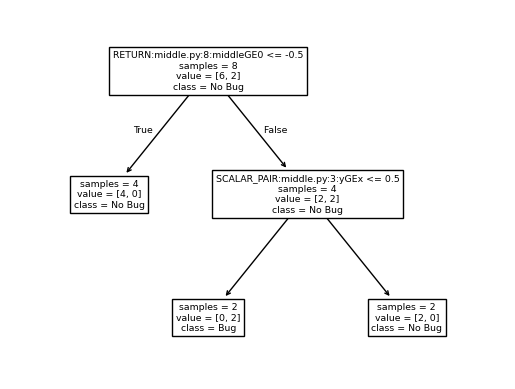

In [17]:
_ = tree.plot_tree(
    oracle.model,
    feature_names=list(map(lambda f: f.name, oracle.all_features)),
    class_names=["No Bug", "Bug"],
    filled=False,
    impurity=False
)

## What Did We Learn? 🎓

BASHIRI successfully identified the bug in our `middle` function!

**Here's what the decision tree reveals:**

The bug occurs when:
- Line 8 gets executed (the second `return y` - when `y < z` and `x < z` but not `x < y`)
- AND `y < x` is true

**In plain English:** When we're in the first branch (`y < z`) and `x` falls between `y` and `z`,
the function incorrectly returns `y` instead of `x`.

**Example:** `middle(3, 2, 8)` should return `3`, but it returns `2`! ❌

The oracle learned this pattern automatically from just a handful of examples. Pretty powerful! 🚀